# Show plots of mutation locations throughout the genomes

In [3]:
%run "Header.ipynb"

In [4]:
%run "LoadMutationJSONData.ipynb"

In [8]:
import time
import skbio
from parse_sco import parse_sco

## Parameters of the diversity index: $p$ and $m$

See paper for description. These are currently copied from the diversity index notebook; ideally, should be loaded from the same place I guess.

In [11]:
m = 5

percentages = [50, 25, 10, 5, 2, 1, 0.5, 0.25, 0.1, 0.05]

p2pct = {p: p / 100 for p in percentages}
p2mincov = {p: m / p2pct[p] for p in percentages}

# We skip 0.25% (since BACTERIA isn't sufficiently covered for it, although I guess we could show CAMP /
# BACTEROIDALES if desired) and we skip 0.1%, 0.05%, etc. since none of the 3 selected genomes are suff.
# covered for these percentages
percentages_were_gonna_use = percentages[:-3]

In [12]:
seq2p2within_gene_muts = {}
seq2p2intergenic_muts = {}
seq2p2sufficiently_covered_positions = {}
seq2p2insufficiently_covered_positions = {}

print(f"Percentages (values of p we're going to use): {percentages_were_gonna_use}")
for si, seq in enumerate(SEQS):
    print(f"On seq {seq}...")

    t1 = time.time()
    print("\tRetrieving sequence-level data...")
    genes_df = parse_sco(f"../seqs/genes/{seq}.sco")
    sequence = str(skbio.DNA.read(f"../seqs/{seq}.fasta"))
    positions = range(1, seq2len[seq] + 1)
    pos_to_genes = get_parent_gene_info_of_many_positions(1, seq2len[seq], genes_df)
    t2 = time.time()
    print(f"\tDone retrieving data. Time taken: {t2 - t1:,.2f} sec.")
    
    p2within_gene_muts = {p: [] for p in percentages_were_gonna_use}
    p2intergenic_muts = {p: [] for p in percentages_were_gonna_use}
    p2sufficiently_covered_positions = {p: [] for p in percentages_were_gonna_use}
    p2insufficiently_covered_positions = {p: [] for p in percentages_were_gonna_use}
    
    print("\tGoing through positions...")
    for pos in positions:
        if pos % 1e5 == 0:
            print(f"\t\tOn position {pos:,} / {seq2len[seq]:,} bp.")
        cov = seq2pos2totalcov[seq][str(pos)]
        for p in percentages_were_gonna_use:
            if cov >= p2mincov[p]:
                # Only call mutations based on individual nt mutations, not aggregates.
                # Similar to diversity index computation.
                nonmatches = set("ACGT") - set(sequence[pos - 1])
                alt_freqs = seq2pos2mismatches[seq][str(pos)]
                for alt in alt_freqs:
                    if (alt_freqs[alt] / cov) > p2pct[p]:
                        num_genes = len(pos_to_genes[pos])
                        if num_genes == 0:
                            p2intergenic_muts[p].append(pos)
                        else:
                            p2within_gene_muts[p].append(pos)
                        break
                p2sufficiently_covered_positions[p].append(pos)
            else:
                p2insufficiently_covered_positions[p].append(pos)
                
    seq2p2within_gene_muts[seq] = p2within_gene_muts
    seq2p2intergenic_muts[seq] = p2intergenic_muts
    seq2p2sufficiently_covered_positions[seq] = p2sufficiently_covered_positions
    seq2p2insufficiently_covered_positions[seq] = p2insufficiently_covered_positions

Percentages (values of p we're going to use): [50, 25, 10, 5, 2, 1, 0.5]
On seq edge_6104...
	Retrieving sequence-level data...
	Done retrieving data. Time taken: 2.34 sec.
	Going through positions...
		On position 100,000 / 1,289,244 bp.
		On position 200,000 / 1,289,244 bp.
		On position 300,000 / 1,289,244 bp.
		On position 400,000 / 1,289,244 bp.
		On position 500,000 / 1,289,244 bp.
		On position 600,000 / 1,289,244 bp.
		On position 700,000 / 1,289,244 bp.
		On position 800,000 / 1,289,244 bp.
		On position 900,000 / 1,289,244 bp.
		On position 1,000,000 / 1,289,244 bp.
		On position 1,100,000 / 1,289,244 bp.
		On position 1,200,000 / 1,289,244 bp.
On seq edge_1671...
	Retrieving sequence-level data...
	Done retrieving data. Time taken: 4.17 sec.
	Going through positions...
		On position 100,000 / 2,153,394 bp.
		On position 200,000 / 2,153,394 bp.
		On position 300,000 / 2,153,394 bp.
		On position 400,000 / 2,153,394 bp.
		On position 500,000 / 2,153,394 bp.
		On position 600,0

On seq edge_6104 (length 1,289,244 bp)...
On seq edge_1671 (length 2,153,394 bp)...
On seq edge_2358 (length 2,806,161 bp)...


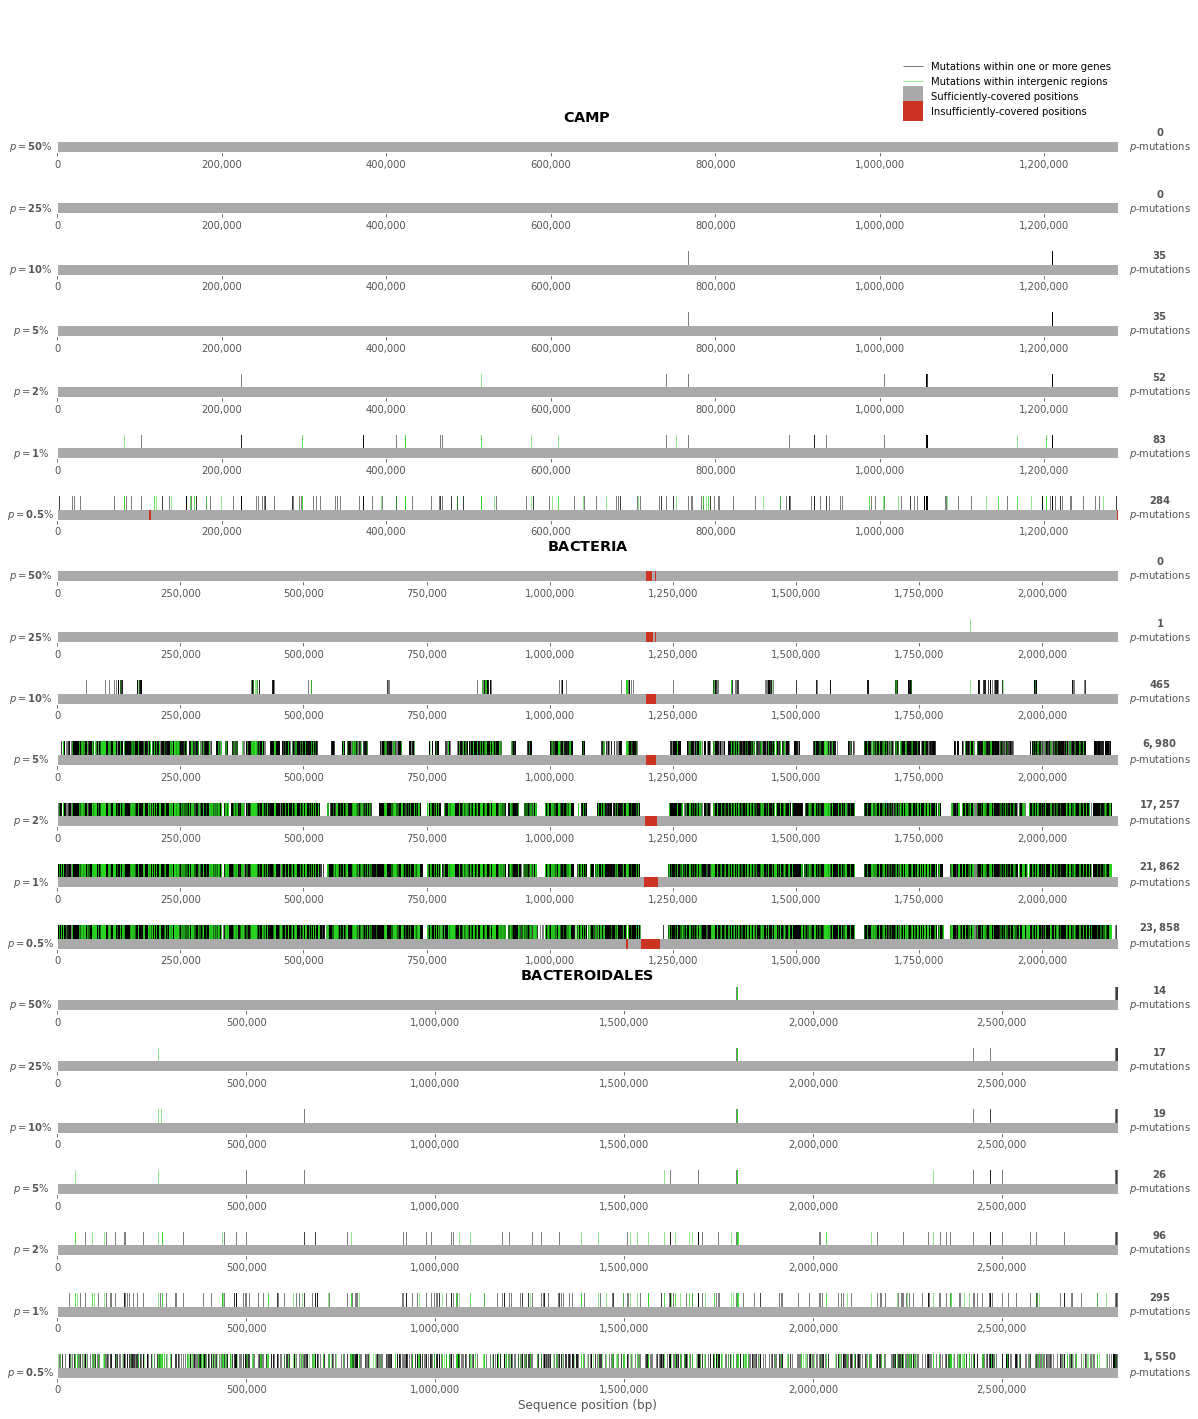

In [65]:
num_rows = 3 * len(percentages_were_gonna_use)
fig, ax = pyplot.subplots(num_rows, 1, gridspec_kw={"hspace": 1.5})

for si, seq in enumerate(SEQS):
    print(f"On seq {seq} (length {seq2len[seq]:,} bp)...")
    for pi, p in enumerate(percentages_were_gonna_use):
        
        ax_idx = (si * len(percentages_were_gonna_use)) + pi
        
        #print(f"\tOn percentage p = {p}%...", end=" ")
        #print(f"axis index: {ax_idx} / {num_rows - 1}")
        
        within_gene_muts = seq2p2within_gene_muts[seq][p]
        intergenic_muts = seq2p2intergenic_muts[seq][p]
        num_p_muts = len(within_gene_muts) + len(intergenic_muts)
        sufficiently_covered_positions = seq2p2sufficiently_covered_positions[seq][p]
        insufficiently_covered_positions = seq2p2insufficiently_covered_positions[seq][p]

        # We use the first ax for BACTERIA because (as of writing) CAMP has no insufficiently covered
        # positions for the top value of p, so no insufficient position info shows up in the legend.
        # BACTERIA, on the other hand, has cov drops -- which actually helps cover all cases we
        # show in the legend in this case.
        if seq == "edge_1671" and pi == 0:
            wgm_label = "Mutations within one or more genes"
            igm_label = "Mutations within intergenic regions"
            sc_label = "Sufficiently-covered positions"
            ic_label = "Insufficiently-covered positions"
        else:
            wgm_label = igm_label = sc_label = ic_label = None

        if ax_idx == num_rows - 1:
            ax[ax_idx].set_xlabel("Sequence position (bp)")

        # Draw vertical lines indicating called p-mutations
        # We make it a point to draw these *before* the horizontal lines so that the horizontal lines
        # are drawn on top
        ax[ax_idx].vlines(within_gene_muts, 0, 1, color="#000000", linewidth=0.5, label=wgm_label)
        ax[ax_idx].vlines(intergenic_muts, 0, 1, color=cp2color[4], linewidth=0.5, label=igm_label)
        
        # Draw horizontal lines indicating sufficiently and insufficiently-covered positions
        for type_of_positions, color, label in (
            (sufficiently_covered_positions, "#aaaaaa", sc_label),
            (insufficiently_covered_positions, "#cc3322", ic_label)
        ):
            if len(type_of_positions) > 0:
                runs = convert_to_runs(type_of_positions)
                run_starts = [r[0] for r in runs]
                run_ends = [r[1] for r in runs]
                ax[ax_idx].hlines(
                    [0] * len(run_starts), run_starts, [s + 1 for s in run_ends],
                    color=color, linewidth=20, label=label
                )
                debug_runs = False
                if debug_runs:
                    if color == "#aaaaaa":
                        prefix = "Sufficiently-covered"
                    else:
                        prefix = "Insufficiently-covered"
                    print(f"\t{prefix} runs for {seq} at p = {p}%:")
                    print(f"\t\tStarts: {run_starts}")
                    print(f"\t\tEnds: {run_ends}")

        if pi == 0:
#             title = f"{seq2name[seq]}: {num_p_muts:,} $p$-mutation"
#             if num_p_muts != 1:
#                 # grammar is hard ok
#                 title += "s"
            # Add p = (p)% newline before the title whenever we switch to a new value of p
            # the bold text is done using fancy latex stuff: https://stackoverflow.com/a/44123579
#             if si == 0:
#                 # Use {,} and {:} to remove unneeded spaces around these characters due to MathTeX stuff:
#                 # https://tex.stackexchange.com/a/303127
#                 msc_int = f"{p2mincov[p]:,.0f}x".replace(",", "{,}")
#                 title = (
#                     r"$\bf{p = " + str(p) + "\\%\ (minimum \ sufficient\ coverage{:}\ " +
#                     f"{msc_int})$\n" + title
#                 )
            ax[ax_idx].set_title(r"$\bf{" + seq2name[seq] + "}$")

        use_thousands_sep(ax[ax_idx].xaxis)
        
        leftlabel = r"$p = \bf{" + str(p) + "}$%"
        rightlabel = r"$\bf{" + f"{num_p_muts:,}" + "}$\n$p$-mutations"
        loffset = seq2len[seq] * 0.025
        roffset = seq2len[seq] * 0.04
        ax[ax_idx].text(-loffset, 0.1, leftlabel, ha="center", color="#555555")
        ax[ax_idx].text(seq2len[seq] + roffset, 0.1, rightlabel, ha="center", color="#555555")
        
        # Hide y-axis numbers / ticks, since they don't really have meaning in this plot:
        # https://stackoverflow.com/a/2176591
        ax[ax_idx].yaxis.set_ticks([])

        ax[ax_idx].set_ylim(0, 1)
        # the purpose of setting the upper x limit is to avoid unsightly things where mutations near the
        # end of a genome "go beyond" the gray/red bars (this happens in BACTEROIDALES esp as of writing).
        # the sequences start at x = 1, technically (we're using 1-indexed coordinates here), but we include
        # x = 0 because having a tick there looks nicer. I guess ideally we'd show a tick at x = 1 instead of
        # x = 0 but that sounds like it might be too much trouble.
        # We include up to 1 above the seq len because each "block" of (in)sufficiently covered positions
        # ranges from [block start in 1-indexed coords, block end in 1-indexed coords + 1] so that blocks
        # of 1 position technically take up space. Think this is reasonable, although granted: 1-pos-length
        # blocks really aren't visible at this range.
        ax[ax_idx].set_xlim(0, seq2len[seq] + 1)

        # Make the plot white: https://stackoverflow.com/a/4708018
        ax[ax_idx].patch.set_facecolor("None")
        ax[ax_idx].patch.set_edgecolor("None")
        ax[ax_idx].patch.set_alpha(0)
    
fig.legend(loc=(0.75, 0.915), facecolor="white", edgecolor="white")
fig.set_size_inches(19, 23)
fig.savefig("figs/mutation-locations.png", bbox_inches="tight")